# Modèle Bagging Classifier

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys
import os
import itertools
import shap
import pickle

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit
from joblib import dump, load

sys.stdout.flush()

def modelAlreadyTrain(filename):
    return os.path.isfile('../models/' + filename)

def savePickleModel(model, filename):
    with open('../models/' + filename, 'wb') as f:
        pickle.dump(model, f)
        f.close()

def loadPickleModel(filename):
    with open('../models/' + filename, 'rb') as f:
        model = pickle.load(f)
        f.close()
        return model

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


## Récupération des données 
### Classification de la valeur cible suivant la nomenclature suivante
<img src="../src/streamlit/img/Labelisation.jpg">

In [2]:
df=pd.read_csv('../../../Data/processed/Co2_final.csv')
def calcTarget(X):
    if X <= 100 :
        return 1
    elif X > 100 and X <= 120:
        return 2
    elif X > 120 and X <= 140:
        return 3
    elif X > 140 and X <= 160:
        return 4
    elif X > 160 and X <= 200:
        return 5
    elif X > 200 and X <= 250:
        return 6
    elif X > 250 :
        return 7


df['target'] = df['Ewltp (g/km)'].apply(lambda x : calcTarget(x))


### Création des jeux de données d'entrainement et des jeux de données de test

In [3]:

X = df.drop(columns=['Ewltp (g/km)', 'ID', 'target'])
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

> Mise à l'echelle des différentes valeurs

In [4]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



### Entrainement du modèle

> Utilisation d'une grid search pour trouver le meilleur paramétrage
>
> Note : Pour des raisons de fludité on va réduire le jeux de données en s'assurant de garder un échantillonnage représentatif des données initiales

In [11]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from tqdm import tqdm
import numpy as np
import sys

def TrainModelBaggingClassifier(X, y, sample_size=500_000):
    # Stratifier les données en fonction des classes de y
    if X.shape[0] > sample_size:
        X, _, y, _ = train_test_split(X, y, train_size=sample_size, random_state=42, stratify=y)
        print(f"Dataset réduit à {sample_size} lignes pour l'entraînement.")

    # Paramètres pour GridSearch
    param_grid = {
        'n_estimators': [100,200],  # Nombre de modèles de base
        'max_samples': [0.5, 1.0],  # Proportion des données utilisées pour chaque modèle
        'max_features': [0.5, 1.0],  # Proportion des caractéristiques utilisées pour chaque modèle
        'estimator__max_depth': [None, 10, 20],  # Profondeur maximale pour les arbres
        'estimator__min_samples_split': [5, 10],  # Critère de division pour les arbres
    }

    # Calcul du nombre total de combinaisons
    total_combinations = (
        len(param_grid['n_estimators']) *
        len(param_grid['max_samples']) *
        len(param_grid['max_features']) *
        len(param_grid['estimator__max_depth']) *
        len(param_grid['estimator__min_samples_split']) *
        3  # cv=3
    )

    # Initialisation de tqdm pour afficher la progression
    pbar = tqdm(total=total_combinations, desc="GridSearch Progress", position=0, leave=True)

    class TqdmWriter:
        """Redirige les logs de verbose vers tqdm."""
        def write(self, message):
            if message.strip():  # Éviter les lignes vides
                pbar.update(1)

        def flush(self):
            pass

    # Création de GridSearch avec un BaggingClassifier
    grid_search = GridSearchCV(
        BaggingClassifier(estimator=DecisionTreeClassifier(), random_state=42),
        param_grid,
        cv=3,
        verbose=3,  # Affiche les logs pour chaque tâche
        n_jobs=1
    )

    # Rediriger stdout pour capturer les logs
    old_stdout = sys.stdout
    sys.stdout = TqdmWriter()

    try:
        grid_search.fit(X, y)
    finally:
        sys.stdout = old_stdout  # Restaurer stdout
        pbar.close()

    print("Meilleurs paramètres trouvés :", grid_search.best_params_)
    return grid_search



# Meilleur parametres trouvées 
"""
{'estimator__max_depth': None, 
'estimator__min_samples_split': 5, 
'max_features': 1.0, 
'max_samples': 1.0, 
'n_estimators': 200}
"""

"\n{'estimator__max_depth': 14, \n'estimator__min_samples_leaf': 1, \n'estimator__min_samples_split': 6, \n'max_features': 0.9413181715946699, \n'max_samples': 0.5943535541706897, \n'n_estimators': 28}\n"

In [15]:
if modelAlreadyTrain('BaggingClassifier.pkl'):
    trainningModel = loadPickleModel('BaggingClassifier.pkl')
else :
    #trainningModel = TrainModelBaggingClassifier(X_train, y_train, 50000)
    trainningModel = BaggingClassifier( estimator=DecisionTreeClassifier(max_depth=None, 
                                                                        min_samples_split=5,
                                                                        random_state=42),
                                        max_features=1.0, 
                                        max_samples=1.0,
                                        n_estimators=200,
                                        random_state=42 )
    trainningModel.fit(X_train, y_train)
    savePickleModel(trainningModel, 'BaggingClassifier.pkl')



In [16]:
from ClassificationModel import ClassificationModel
Model = ClassificationModel('BaggingClassifier',
                               trainningModel, 
                               X_train, 
                               X_test, 
                               y_train, 
                               y_test, 
                               X.columns)

Model.predictModel()
Model.calcScore()
Model.displayScore()

<class 'sklearn.ensemble._bagging.BaggingClassifier'>
RMSE Jeux d entrainement : 0.10819027120080192
RMSE Jeux de test : 0.10943947076847303
Score du modèle train (R²) 0.9883073695582896
Score du modèle test (R²) 0.9880530126129319
Classification Report :
              precision    recall  f1-score   support

           A       1.00      1.00      1.00    109882
           B       0.98      0.98      0.98    134814
           C       0.99      0.99      0.99    242103
           D       0.99      0.99      0.99    118751
           E       0.99      0.99      0.99     62022
           F       1.00      0.99      0.99     24560
           G       1.00      0.99      1.00      7626

    accuracy                           0.99    699758
   macro avg       0.99      0.99      0.99    699758
weighted avg       0.99      0.99      0.99    699758



> Sauvegarde des scores du modèle

In [17]:
Model.writeResults()

### Représentation graphique des résultats du modèle
> Affichage de la matrice de confusion

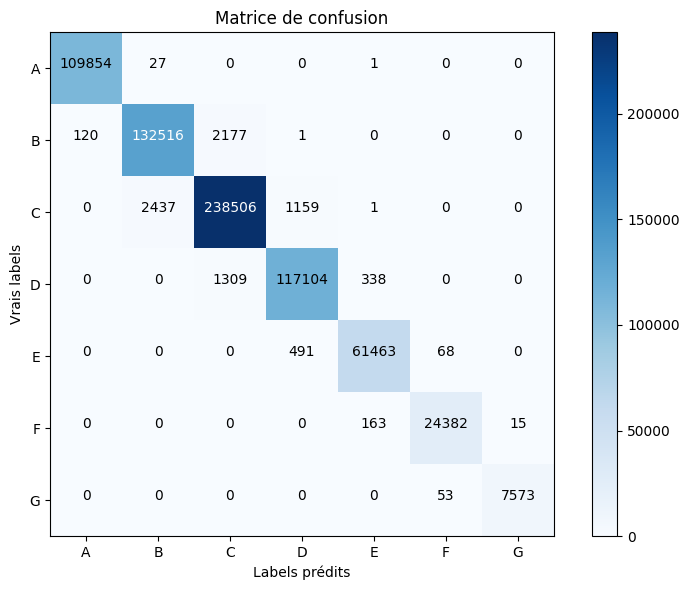

In [18]:
Model.displayConfusionMatrix()

In [19]:
trainningModel.estimator_.__dict__

{'criterion': 'gini',
 'splitter': 'best',
 'max_depth': None,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'min_weight_fraction_leaf': 0.0,
 'max_features': None,
 'max_leaf_nodes': None,
 'random_state': 42,
 'min_impurity_decrease': 0.0,
 'class_weight': None,
 'ccp_alpha': 0.0,
 'monotonic_cst': None}

### Interpretabilité du modèle
> Affichage de l'importance de chaque feature

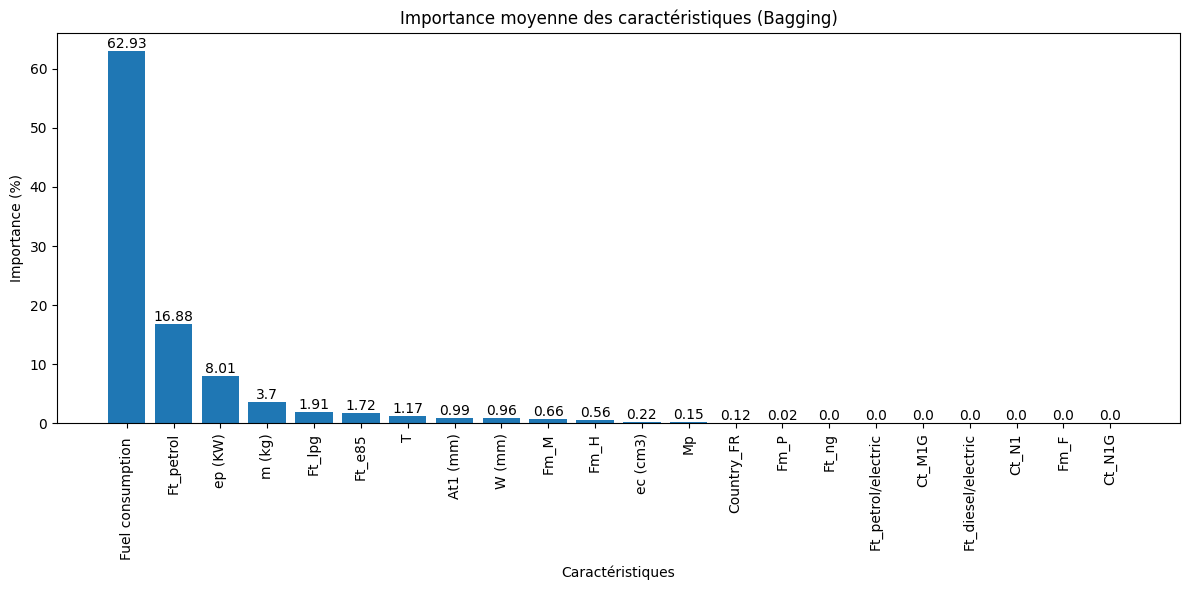

In [20]:
Model.displayFeatureImportances()

> Les temps de calcul de l'analyse SHAP, nous oblige à limiter le nombre de valeurs examinées

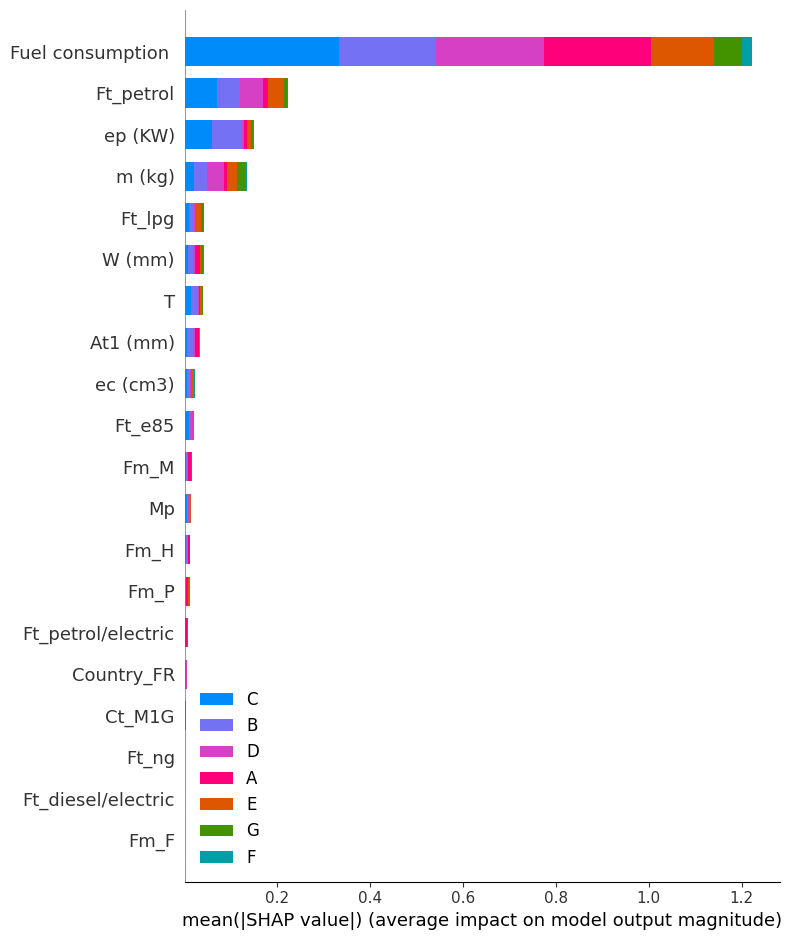

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


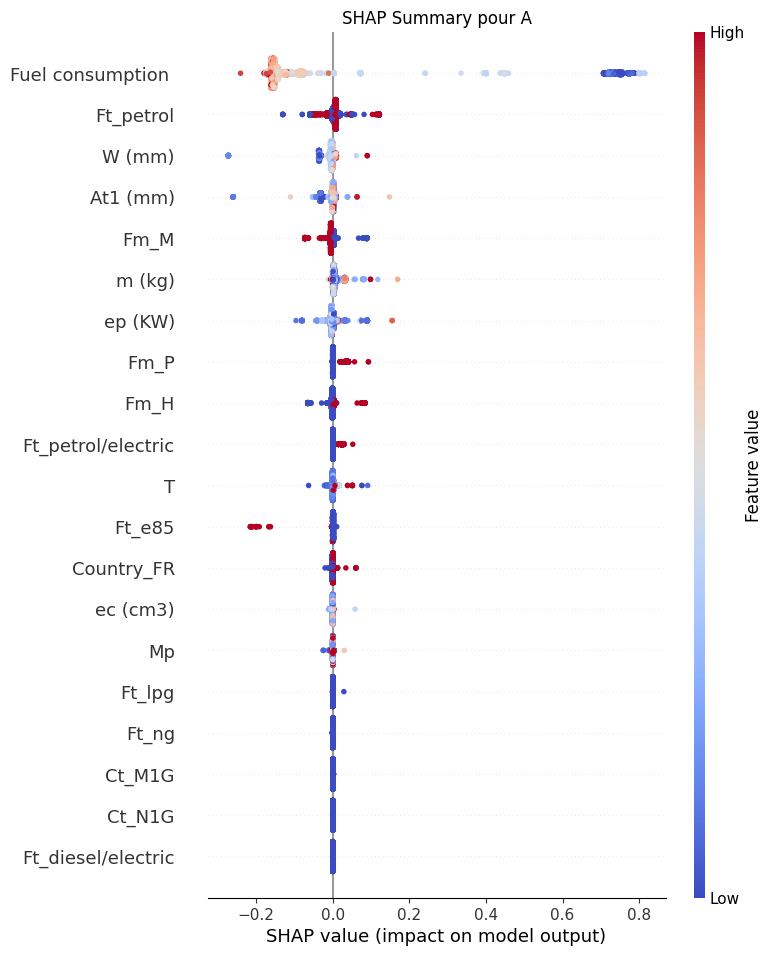

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


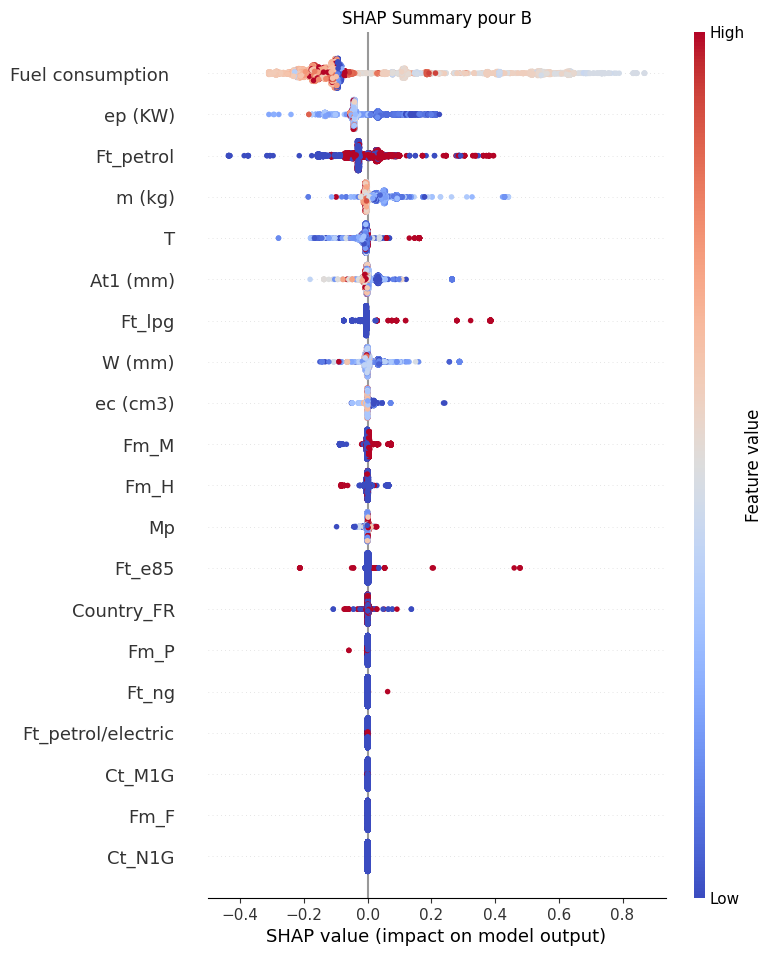

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


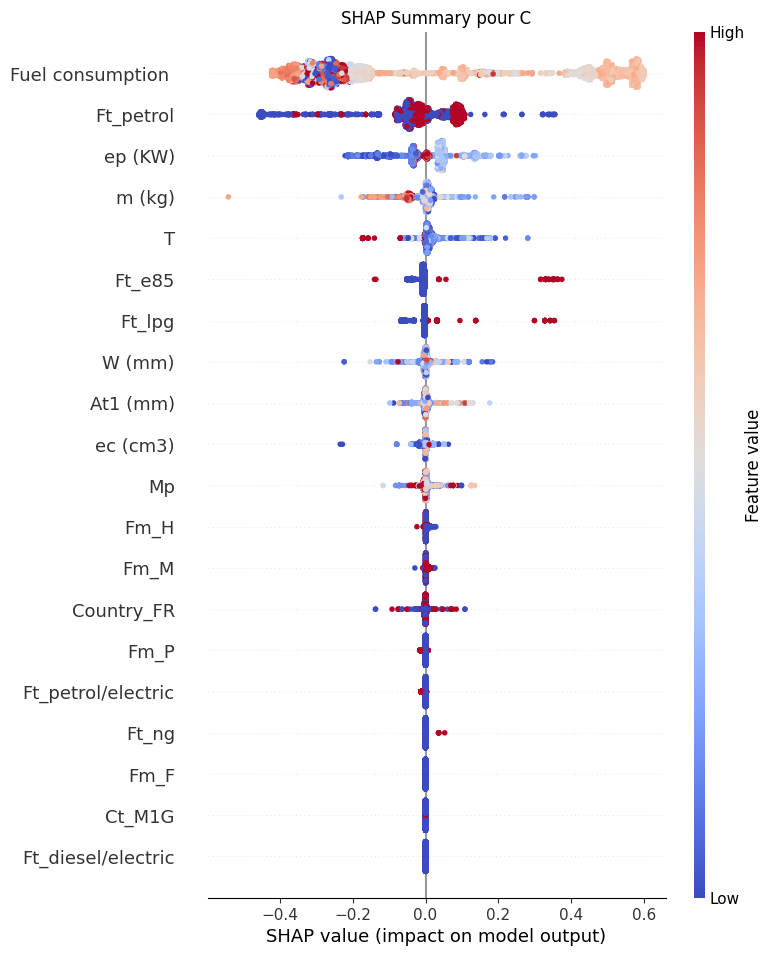

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


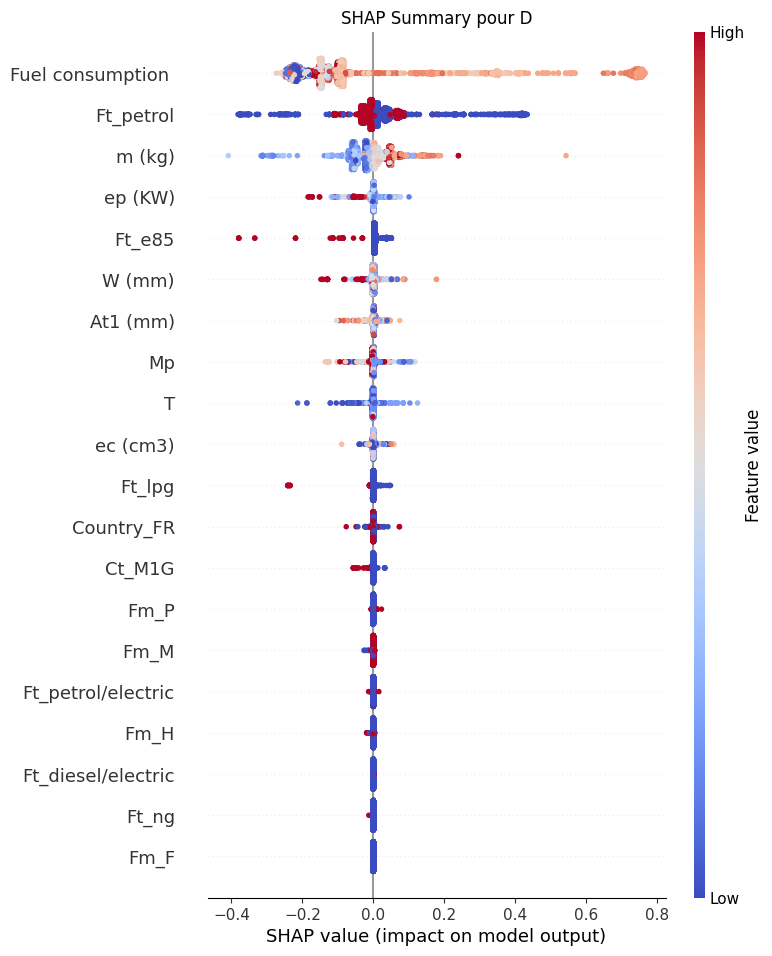

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


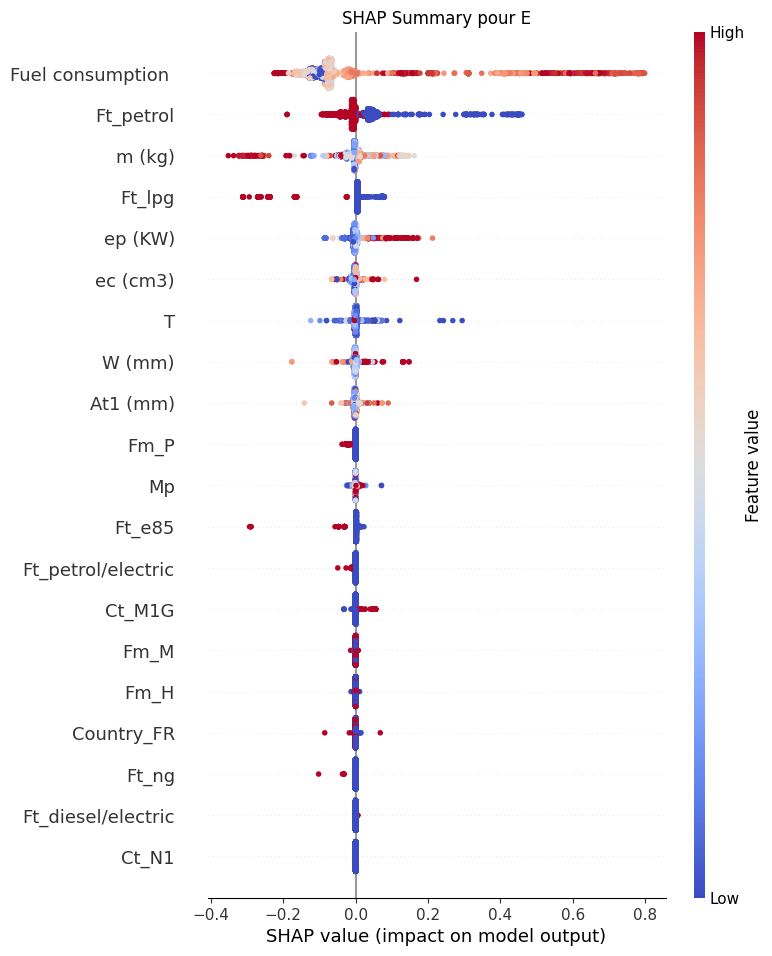

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


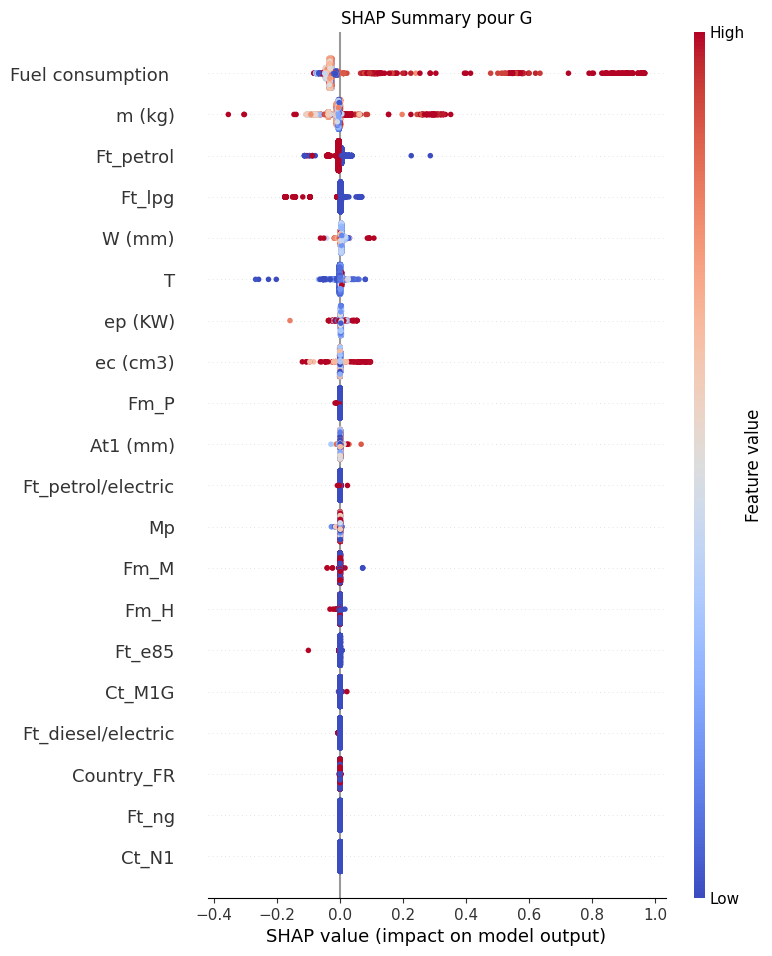

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


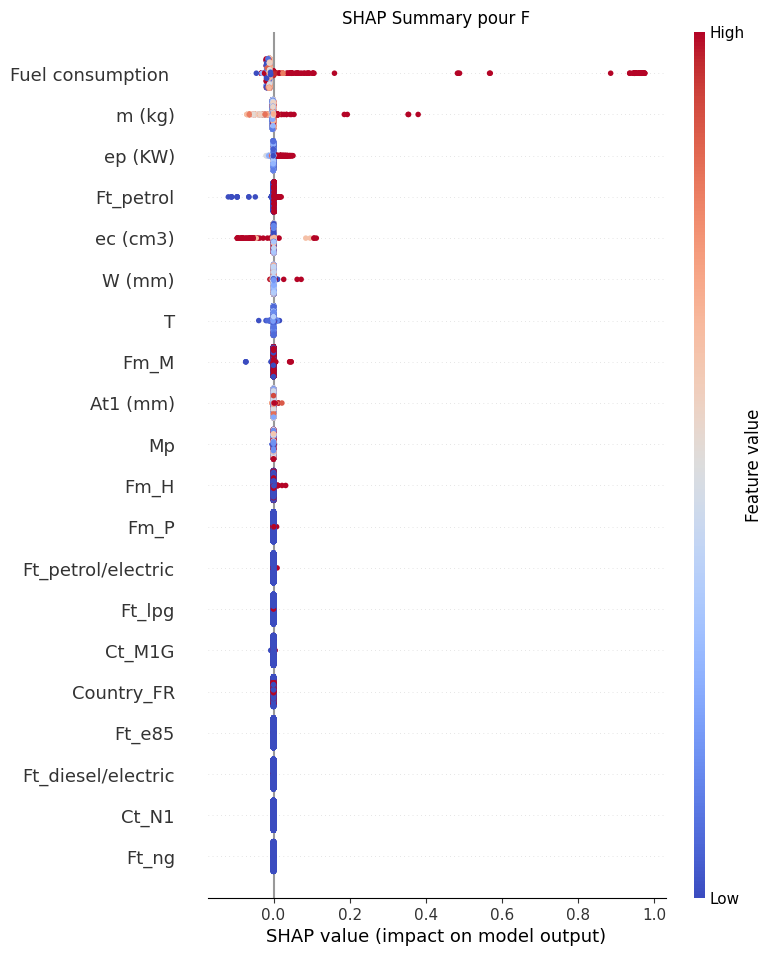

In [22]:
Model.displayShap(5000)